In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from glob import glob
import sys
import sklearn.metrics as metrics

In [ ]:
# This is needed to display the images.
%matplotlib inline

# Detect the traffic lights in an image

### Download pretrained model

In [ ]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

init_data_set = '../input/cropped-lisa-traffic-light-dataset/cropped_lisa_1/train_1'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
model_path = "./"
PATH_TO_CKPT = model_path + MODEL_NAME + '/frozen_inference_graph.pb'


def download_model():
    import six.moves.urllib as urllib
    import tarfile

    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
        file_name = os.path.basename(file.name)
        if 'frozen_inference_graph.pb' in file_name:
            tar_file.extract(file, os.getcwd())

### Code for detection

In [ ]:
def load_graph():
    if not os.path.exists(PATH_TO_CKPT):
        download_model()

    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.compat.v2.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    return detection_graph

def select_boxes(boxes, classes, scores, score_threshold=0, target_class=10):
    """

    :param boxes:
    :param classes:
    :param scores:
    :param target_class: default traffic light id in COCO dataset is 10
    :return:
    """

    sq_scores = np.squeeze(scores)
    sq_classes = np.squeeze(classes)
    sq_boxes = np.squeeze(boxes)

    sel_id = np.logical_and(sq_classes == target_class, sq_scores > score_threshold)

    return sq_boxes[sel_id]

class TLClassifier(object):
    def __init__(self):

        self.detection_graph = load_graph()
        self.extract_graph_components()
        self.sess = tf.compat.v1.Session(graph=self.detection_graph)

        # run the first session to "warm up"
        dummy_image = np.zeros((100, 100, 3))
        self.detect_multi_object(dummy_image,0.1)
        self.traffic_light_box = None
        self.classified_index = 0

    def extract_graph_components(self):
        # Definite input and output Tensors for detection_graph
        self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
        self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
        self.num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')
    
    def detect_multi_object(self, image_np, score_threshold):
        """
        Return detection boxes in a image

        :param image_np:
        :param score_threshold:
        :return:
        """

        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Actual detection.

        (boxes, scores, classes, num) = self.sess.run(
            [self.detection_boxes, self.detection_scores, self.detection_classes, self.num_detections],
            feed_dict={self.image_tensor: image_np_expanded})

        sel_boxes = select_boxes(boxes=boxes, classes=classes, scores=scores,
                                 score_threshold=score_threshold, target_class=10)

        return sel_boxes


In [ ]:
tlc=TLClassifier()

In [ ]:
def crop_roi_image(image_np, sel_box, w_padding, h_padding):
    im_height, im_width, _ = image_np.shape
    (left, right, top, bottom) = (sel_box[1] * im_width - w_padding, sel_box[3] * im_width + w_padding,
                                  sel_box[0] * im_height - h_padding, sel_box[2] * im_height + h_padding)
  
    cropped_image = image_np[int(top):int(bottom), int(left):int(right), :]
    return cropped_image

def crop_roi_image_adaptive(image_np, sel_box):
    im_height, im_width, _ = image_np.shape
    factor = 0.4
    (left, right, top, bottom) = ((sel_box[1] - factor*abs(sel_box[1] - sel_box[3])) * im_width, (sel_box[3] + factor*abs(sel_box[1] - sel_box[3])) * im_width,
                                  (sel_box[0] - factor*abs(sel_box[0] - sel_box[2])) * im_height, (sel_box[2] + factor*abs(sel_box[0] - sel_box[2])) * im_height)
    cropped_image = image_np[int(top):int(bottom), int(left):int(right), :]
    return cropped_image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


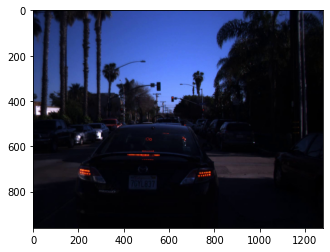

In [ ]:
%time
test_file = "drive/MyDrive/LisaSet/daySequence1/frames/daySequence1--00919.jpg"
##test_file = './3.jpg'
##test_file = "/kaggle/input/lisa-traffic-light-dataset/sample-dayClip6/sample-dayClip6/frames/dayClip6--00332.jpg"
from PIL import Image
im = Image.open(test_file)
image_np = np.asarray(im)
plt.imshow(image_np)

In [ ]:
%time
def crop_single_item(savepath : str, im_path : str):
  im = Image.open(im_path)
  np_im = np.asarray(im)
  boxes=tlc.detect_multi_object(np_im, score_threshold=0.2)
  if len(boxes)>0:
      cropped_image=crop_roi_image_adaptive(np_im,boxes[0])
      plt.imshow(cropped_image)
      immmm = Image.fromarray(cropped_image)
      immmm.save(savepath)
  else:
    print("Traffic light not found")
    return

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


In [ ]:
def crop_files(f_name_input : str, files):
  for i in range(len(files)):
    path_save = f'drive/MyDrive/Crop/{f_name_input}--{i}.jpg'
    try:
      crop_single_item(path_save, files[i])
    except:
      continue
    print(f'{f_name_input}--{i} from {len(files)} : {f_name_input}')

def crop_data_set():
  dirs = glob("drive/MyDrive/LisaSet/*")
  f_name = dirs[0].split('/')[-1]
  for j in range(len(dirs)):
    f_name = dirs[j].split('/')[-1]
    f_d = glob(f'{dirs[j]}/frames/*.jpg')
    crop_files(f_name, f_d)
    

crop_data_set()
##v = glob("drive/MyDrive/LisaSet/daySequence2/frames/*.jpg")
##crop_files('DayS2', v)

Выходные данные были обрезаны до нескольких последних строк (5000).
dayClip5--4 from 2667 : dayClip5
dayClip5--5 from 2667 : dayClip5
dayClip5--6 from 2667 : dayClip5
dayClip5--7 from 2667 : dayClip5
dayClip5--8 from 2667 : dayClip5
dayClip5--9 from 2667 : dayClip5
dayClip5--10 from 2667 : dayClip5
dayClip5--11 from 2667 : dayClip5
dayClip5--12 from 2667 : dayClip5
dayClip5--13 from 2667 : dayClip5
dayClip5--14 from 2667 : dayClip5
dayClip5--15 from 2667 : dayClip5
dayClip5--16 from 2667 : dayClip5
dayClip5--17 from 2667 : dayClip5
dayClip5--18 from 2667 : dayClip5
dayClip5--19 from 2667 : dayClip5
dayClip5--20 from 2667 : dayClip5
dayClip5--21 from 2667 : dayClip5
dayClip5--22 from 2667 : dayClip5
dayClip5--23 from 2667 : dayClip5
dayClip5--24 from 2667 : dayClip5
dayClip5--25 from 2667 : dayClip5
dayClip5--26 from 2667 : dayClip5
dayClip5--27 from 2667 : dayClip5
dayClip5--28 from 2667 : dayClip5
dayClip5--29 from 2667 : dayClip5
dayClip5--30 from 2667 : dayClip5
dayClip5--31 from 26